# 使用RNN进行名字分类

参考链接：[CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#classifying-names-with-a-character-level-rnn)

在这个demo中，我们会构建并训练基本的字符级别的RNN来对单词进行分类。

我们将会训练来自18种语言的几千个姓氏，并根据拼写预测名称来自哪个语言。

## 前置技能

- 已经安装好了PyTorch
- 知道 Python 的用法
- 了解 PyTorch 和 Tensor 的用法
- 了解 RNN 的用途和工作方式
- （可选）了解 LSTM 网络

## 代码分析

这里我们会对代码进行一定的分析，因为源代码中有一些比较少用的或者冷门的方法。原链接中缺乏比较详细的分析，这里会有一定讲解，没学过的正好学一学，学过的就当复习。

>记得先下载数据集！

### 准备数据

In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Japanese.txt', 'data/names/Portuguese.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Italian.txt']


上面这段代码要注意的是：

```Python
import glob

def findFiles(path): return glob.glob(path)
```

在这段代码中，glob.glob() 方法起到的作用是返回所有路径下符合条件的文件名列表。

在这里，我们的数据集是保存在多个 .txt 文件中的，所以我们会利用 glob 方法来搜索 .txt 文件，然后打印出来。

```Python
print(findFiles('data/names/*.txt'))
```

可以看见输出了一个列表，列表中的每个元素都是当前路径下txt文件的路径。

In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(all_letters)
print(n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))
print(unicodeToAscii('Klüft skräms inför på fédéral électoral große'))


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57
Slusarski
Kluft skrams infor pa federal electoral groe


上面一段代码主要是将字符串从 Unicode 编码转换为 ASCII 编码。

参考链接1：[What is the best way to remove accents in a Python unicode string?](https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-in-a-python-unicode-string/518232#518232)

参考链接2：[python unicodedata用法](https://blog.csdn.net/xc_zhou/article/details/82079753)

参考链接3：[Python3基础:String模块ascii_letters和digits](https://blog.csdn.net/killmice/article/details/53118884)

------------------
其中：

> ```Python
> all_letters = string.ascii_letters + " .,;'"
> n_letters = len(all_letters)
> ```

这里 string.ascii_letters 生成了ASCII编码的英文大小写字母，外加三个标点符号，然后存入all_letters。

n_letters 则输出了总长度。这里主要是为了后面的字符转换做准备。

----------------------------------------
然后：

> ```Python
> def unicodeToAscii(s):
>     return ''.join(
>         c for c in unicodedata.normalize('NFD', s)
>         if unicodedata.category(c) != 'Mn'
>         and c in all_letters
>     )
> ```

- unicodedata.normalize(form, unistr)：把一串 Unicode 字符串转换为普通格式的字符串。

   Unicode标准定义了四种规范化形式： 
   > Normalization Form D (NFD)
   >
   > Normalization Form KD (NFKD)
   >
   > Normalization Form C (NFC)
   >
   > Normalization Form KC (NFKC)
   
   NFD和NFKD将可能的字符进行分解，而NFC和NFKC将可能的字符进行组合。


- unicodedata.category(chr)：该方法返回的是字符在 Unicode 里面的分型，其中‘Mn’表示‘[Mark, Nonspacing](http://www.fileformat.info/info/unicode/category/Mn/list.htm)’类型，主要是一些符号。

------------------------

总而言之，这段代码就是先把 Unicode 编码转换为普通格式字符，同时保证这些字符是英文字符，例如：

>转换前：Klüft skräms inför på fédéral électoral große
>
>转换后：Kluft skrams infor pa federal electoral groe

In [3]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

首先我们建立一个空字典和一个空列表。

In [4]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

然后我们编写一个函数，该函数的作用是把某个 .txt 文件中的每一行读进lines，同时进行ASCII转换。

In [5]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]  # 获取分类
    all_categories.append(category)  # 分类添加到list
    lines = readLines(filename)  # 每一行读取
    category_lines[category] = lines  # 把相关字符和对应分类放入字典

n_categories = len(all_categories)

现在我们有category_lines，一个将每个类别（语言）映射到一个行（名称）列表的字典。

我们还有all_categories（语言列表）和 n_categories （语言数量）供以后参考。

测试一下意大利语、法语前五个名字？

In [6]:
print(category_lines['Italian'][:5])
print(category_lines['French'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']


现在我们需要将名称转化为 Tensor 来使用它们。

假设你知道什么叫 One-Hot 编码，或者叫独热编码（如果不懂快去查一查，很简单的一种表示方法）。我们把单个字母都表示成这种独热编码矢量，比如字母 b 可以表示为 <0 1 0 0 0 ... 0 0 0>。

为了形成一个单词，我们会将其加入到一个二维矩阵中，矩阵形式为<line_length x 1 x n_letters>。

其中，额外出现了1个维度，因为PyTorch假设所有东西都是（batches）批量的，这里我们的batch size是1。

--------------------

接下来我们看代码：

In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

这部分代码首先导入了torch。

然后编写一个函数：输入一个字母，然后在all_letters里面找到字母的索引，比如"a"的索引就是0。

In [8]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

这个函数的作用是把字母转化为 Tensor。

1. 首先建立一个全为0的 Tensor
2. 其次使用letterToIndex()函数把tensor中字母的对应index转化为1（独热编码）
3. 返回字母对应的独热码tensor

可以通过如下代码验证：

In [9]:
tensor_zero = torch.zeros(1, n_letters)
tensor_zero

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [10]:
tensor_a = letterToTensor('a')
print(tensor_a)
print(tensor_a.size())

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 57])


并且我们知道了，57指代的是大小写字母加四个标点符号。

In [12]:
# Turn a line into a <line_length x 1 x n_lettes>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


这里的函数就是把单词转化为一个三维tensor矩阵了，矩阵的每一个切片代表一个字母。

以 'Jones' 为例，lineToTensor() 函数输出了一个 5×1×57 的三维矩阵。5表示有五个字母。

### 搭建网络

在 Torch 中创建一个[循环神经网络](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#example-2-recurrent-net)。

这个RNN模块只有两个线性层，在输入和隐藏层运行，然后输出到 LogSoftmax 层，是一个很简单的结构。



In [25]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

if torch.cuda.is_available():  # 如果GPU可以使用
    rnn = rnn.cuda()
    print("CUDA is available.")

CUDA is available.


简单过一下RNN结构：

![RNN](RNN.png)

在代码中：

> ```Python
> self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
> ```

这段代码代表的就是隐藏状态$ h^{(t)} $，接收的是$ Wh^{(t-1)} + Ux^{(t)} $的经过线性变换输出，其中 t 是时间步，注意：这里没有写激活函数 tanh 和偏置b。

> ```Python
> self.i2o = nn.Linear(input_size + hidden_size, output_size)
> ```

这段代码代表的则是输入$ Wh^{(t-1)} + Ux^{(t)} $，经过线性变换到输出$ o^{(t)} $。

直观上来看这里似乎和公式不大一样？

根据 RNN 的更新方程（参见《深度学习》第10章）考虑到

1. $ o^{(t)} = c + Vh^{(t)} $，其中$ c $是偏置，这里$ c $为$ 0 $，所以有：


2. $ o^{(t)} = Vh^{(t)} $，已知$ h^{(t)} = Wh^{(t-1)} + Ux^{(t)}$，故：


3. $ o^{(t)} = V(Wh^{(t-1)} + Ux^{(t)}) = VWh^{(t-1)} + VUx^{(t)} $

应当依旧是一个关于$ h^{(t-1)} $和$ x^{(t)} $的线性变换，所以依旧用一个Linear层实现。

最后，输出再经过一次softmax计算即可。

----------------------
接下来再看看前向传播的结构，首先：
> ```Python
> combined = torch.cat((input, hidden), 1)
> ```

这条代码中， torch.cat() 就是将两个 tensor 拼接在一起，0表示按维度0（行，竖着）拼接，1表示按维度1（列，横着）拼接。

这里将本时间步的 input 和 上一时间步的 hidden 拼接起来，存入 combined 中，即公式：$ Wh^{(t-1)} + Ux^{(t)} $ 。

---------------------------------------
接下来：
> ```Python
> hidden = self.i2h(combined)
> output = self.i2o(combined)
> ```

这两条代码表示隐藏层hidden的更新（从$ h^{(t)} $到$ h^{(t-1)} $），同时输出$ o^{(t)} $。

-------------------------------------
最后：
> ```Python
> output = self.softmax(output)
> ```
表示使用 softmax 函数对$ o^{(t)} $做一个多分类（概率之和为1），即公式：$ \vec{y} = softmax(o^{(t)}) $。

到这里位置，RNN 网络就基本编写完成了，剩下的就是隐藏层初始化，全部置零即可，这里不多讲。

-------------------------------
> ```Python
> n_hidden = 128
> rnn = RNN(n_letters, n_hidden, n_categories)
> ```

回顾一下：

- n_letters：57，就是大小写英文字母加四个字符的数量
- n_hidden：128，人工设定的超参数。
- n_categories：18，语言种类数量。

### 运行网络

由于RNN的特殊性，我们在开始运行网络的时候，除了传递一个输入$ x^{(t)} $以外，还需要传递一个隐藏状态$ h^{(t-1)} $，这里在最开始的时候我们是没有这个隐藏状态信息的，因此我们人工将其置零。

以下是例子：

In [29]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

if torch.cuda.is_available():
    input = input.cuda()
    hidden = hidden.cuda()

output, next_hidden = rnn(input, hidden)

上述代码展现了：

1. 将字母 'A' 转化为 tensor
2. 初始化 RNN 隐藏层，即：将$ h^{(t-1)} $初始化为全0
3. 输出output，然后把$ h^{(t-1)} $变为$ h^{(t)} $

In [39]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

if torch.cuda.is_available():
    input = input.cuda()
    hidden = hidden.cuda()

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9842, -2.9652, -2.9291, -2.8791, -3.0062, -2.8114, -2.9417, -2.8936,
         -2.9078, -2.8974, -2.8897, -2.8058, -2.8570, -2.8242, -2.8537, -2.8581,
         -2.8200, -2.9323]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


出于效率的原因，我们不能一个字母一个字母地创建 Tensor，所以之前编写的函数 lineToTensor() 就有用了，它可以直接把一个单词转化为一个三维的 Tensor。

打印输出，我们可以看见输出output，即$ o^{(t)} $是一个 <1 × n_categories> 的 Tensor，其中每个元素都是该单词属于该类别的可能性（越高就越可能）。

### 准备训练

在正式开始前，我们还要对网络的输出做一些解释，比如我们知道output中包含的是每个类别的可能性，但是这里会有一些可读性上面的问题，所以我们要提取对其做一些处理：

In [40]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    # print(top_i)
    # print(top_n)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 11)


实际上这个函数就是把种类的索引变成名称。

>```Python
top_n, top_i = output.topk(1)
category_i = top_i[0].item()
>```

使用 Tensor.topk 来返回最大值的索引，其中 top_n 是最大值，top_i 是索引。

------------------

接下来我们快速获取一些训练例子：

In [41]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Saliba
category = Portuguese / line = Cabral
category = Polish / line = Brzezicki
category = Vietnamese / line = Giang
category = French / line = Durand
category = Greek / line = Gianakopulos
category = Arabic / line = Hanania
category = Scottish / line = Burns
category = Portuguese / line = Cardozo
category = Chinese / line = Hew


### 开始训练

这里要说明的是，我们的损失函数使用的是 torch.nn.NLLLoss() 方法。

torch.nn.NLLLoss() 和 torch.nn.CrossEntropyLoss() 的区别在于：CrossEntropyLoss 额外实现了一次 softmax。

也就是说：

- 如果网络的最后一层输出不带 softmax，就使用 CrossEntropyLoss；
- 如果网络的最后返回的已经是 log_softmax，就使用NLLLoss。

-----------------

在每一轮输入中，我们会：

- 创建输入 input 和目标 target 张量（tensors）
- 创建一个全为0的初识隐藏状态（hidden state）
- 阅读每一个字母，然后
    - 为下个字母保持隐藏状态
- 把最终输出和目标 target 比较
- 反向传播
- 返回输出和损失


In [43]:
criterion = nn.NLLLoss()  # 损失函数

learning_rate = 0.005  # 学习率

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()  # 初始化隐藏层
    if torch.cuda.is_available():
        category_tensor = category_tensor.cuda()
        line_tensor = line_tensor.cuda()
        hidden = hidden.cuda()
    rnn.zero_grad()  # 梯度归零

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)  # 损失函数
    loss.backward()  # 反向传播

    # Add parameters' gradients to their values, multiplied by learning rate
    # 这里相当于手动实现的优化器
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

上述代码定义了训练函数，这个训练函数会返回输出和损失，我们最后取平均损失。

In [44]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

上述设置为画图和跟踪损失函数做准备。

In [45]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

上述函数为时间转换。

In [46]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    if torch.cuda.is_available():
        category_tensor = category_tensor.cuda()
        line_tensor = line_tensor.cuda()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss  # 叠加loss

    # 打印 iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 把当前的平均损失放到losses列表中
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 18s) 2.4998 You / Chinese ✗ (Korean)
10000 10% (0m 34s) 1.7106 Bach / Vietnamese ✓
15000 15% (0m 51s) 2.5848 Chicken / Irish ✗ (Czech)
20000 20% (1m 8s) 1.1811 Mclaughlin / Scottish ✓
25000 25% (1m 26s) 1.2525 Ta / Vietnamese ✓
30000 30% (1m 41s) 2.9325 Ross / Greek ✗ (Scottish)
35000 35% (1m 56s) 0.3070 Teshigahara / Japanese ✓
40000 40% (2m 13s) 3.4039 Gavril / French ✗ (Greek)
45000 45% (2m 33s) 0.5393 Schneiders / Dutch ✓
50000 50% (2m 50s) 1.0933 Komine / Japanese ✓
55000 55% (3m 7s) 2.4431 Chaim / Korean ✗ (Chinese)
60000 60% (3m 24s) 0.9031 Sneiders / Dutch ✓
65000 65% (3m 38s) 1.5369 Hong / Chinese ✗ (Korean)
70000 70% (3m 53s) 0.6943 Lavoie / French ✓
75000 75% (4m 11s) 1.5824 Nunes / Portuguese ✓
80000 80% (4m 25s) 0.3889 Daher / Arabic ✓
85000 85% (4m 41s) 0.7784 Duyava / Czech ✓
90000 90% (4m 57s) 0.0420 Hasainov / Russian ✓
95000 95% (5m 10s) 0.3183 Yi / Korean ✓
100000 100% (5m 24s) 0.4651 Schafer / German ✓


上述代码比起原版代码，新增了GPU判断。其余功能和原版代码一样。

-------------------------

### 绘制结果

我们将训练过程中的历史结果存在了列表 all_losses 里面，现在我们将其画出：

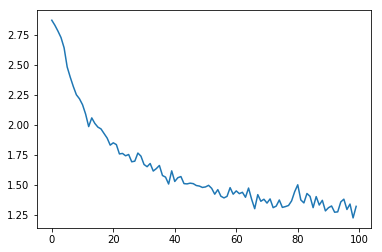

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

### 评估结果

我们将使用混淆矩阵（confusion matrix）来展示判断结果，混淆矩阵是一种判断模型效果的好方法。如果不懂混淆矩阵，可以先了解一下，这里不多讲。

本节代码解析待补充

In [50]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

In [53]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    if torch.cuda.is_available():
        hidden = hidden.cuda()
        line_tensor = line_tensor.cuda()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [54]:
# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

In [55]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

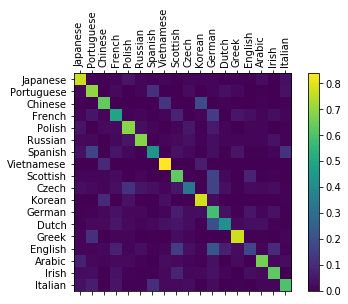

In [56]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()